# 猫狗数据自定义训练

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

tf.__version__

'2.0.0'

## 准备数据集

In [2]:
# 数据集目录
image_dir = "dataset\\dog_and_cat"

#### 准备训练集

In [3]:
# 训练集路径
train_path = os.path.join(image_dir, "train")

In [4]:
# 数据集路径
train_image_path = glob.glob(train_path + "\\*\\*")
print(train_image_path[0])
train_num = len(train_image_path)
print(train_num)

dataset\dog_and_cat\train\cat\cat.0.jpg
2000


In [5]:
train_image_path[0].split('\\')[-2]

'cat'

In [6]:
# 训练集标签 cat:1, dog:0
train_label = [int(path.split('\\')[-2]=='cat') for path in train_image_path]
print("train_label[:5]:", train_label[:5])
print("train_label[-5:]:", train_label[-5:])

train_label[:5]: [1, 1, 1, 1, 1]
train_label[-5:]: [0, 0, 0, 0, 0]


In [7]:
# 创建数据集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_label))
train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [8]:
# 数据处理
def data_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    # 转为灰度图
    #image = tf.image.rgb_to_grayscale(image)
    # 数据增强
    image = tf.image.resize(image, (150, 150))
    #image = tf.image.random_crop(image, [256, 256, 1])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # 归一化
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    label = tf.reshape(label, [1])
    return (image, label)

In [9]:
#If num_parallel_calls=`tf.data.experimental.AUTOTUNE`, then the number of parallel calls is set dynamically based on available CPU.
train_dataset = train_dataset.map(data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset

<ParallelMapDataset shapes: ((150, 150, 3), (1,)), types: (tf.float32, tf.int32)>

cat


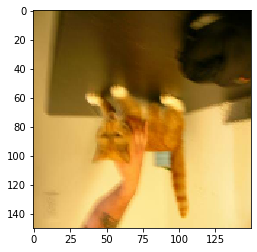

In [10]:
# 打印第一张图片
for image, label in train_dataset.take(1):
    plt.imshow(image.numpy().squeeze())
    print('cat' if label.numpy()[0] == 1 else 'dog')

In [11]:
# 数据集处理
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(train_num).batch(BATCH_SIZE)
# 训练时预取一个batch的数据
train_dataset = train_dataset.prefetch(1)
train_dataset

<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 1)), types: (tf.float32, tf.int32)>

#### 准备测试集

In [12]:
# 测试集路径
test_path = os.path.join(image_dir, "test")
# 数据集路径
test_image_path = glob.glob(test_path + "\\*\\*")
# 标签 cat:1, dog:0
test_label = [int(path.split('\\')[-2]=='cat') for path in test_image_path]
# 创建数据集
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_label))

# 数据处理
def test_data_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, (150, 150))
    # 归一化
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    label = tf.reshape(label, [1])
    return (image, label)

#If num_parallel_calls=`tf.data.experimental.AUTOTUNE`, then the number of parallel calls is set dynamically based on available CPU.
test_dataset = test_dataset.map(test_data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 数据集处理
BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)
# 测试时预取一个batch的数据
test_dataset = test_dataset.prefetch(1)
test_dataset

<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 1)), types: (tf.float32, tf.int32)>

## 构建模型

In [13]:
model = keras.Sequential([
    # Conv1
    keras.layers.Conv2D(64, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    # Conv2
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    # Conv3
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    # Conv4
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    # Dense
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 69, 69, 128)       5

In [14]:
# 创建一个优化器实例
optimizer = tf.keras.optimizers.Adam()

In [15]:
# 创建loss函数的计算方式
loss_func = tf.keras.losses.BinaryCrossentropy()

In [16]:
# 创建评估训练的指标
train_loss = tf.keras.metrics.Mean("train_loss")
train_acc = tf.keras.metrics.BinaryAccuracy("train_acc")
# 训练一步
def train_one_step(model, x, y_true):
    with tf.GradientTape() as t:
        # 计算损失
        y_pred = model(x, training=True)
        loss = loss_func(y_true, y_pred)
    #print(y_pred)
    # 计算梯度
    gradients = t.gradient(loss, model.trainable_variables)
    # 更新参数
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # 计算训练集的评估指标
    train_loss(loss)
    train_acc(y_true, y_pred)

In [17]:
# 创建测试集评估指标
test_loss = tf.keras.metrics.Mean("test_loss")
test_acc = tf.keras.metrics.BinaryAccuracy("test_acc")
# 测试一步
def test_one_step(model, x, y_true):
    y_pred = model(x, training=False)
    loss = loss_func(y_true, y_pred)
    # 计算训练集的评估指标
    test_loss(loss)
    test_acc(y_true, y_pred)

In [18]:
# 保存训练过程的列表
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []
def train(model, train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        # 一次取出一个batch进行训练
        for (x, y_true) in train_dataset:
            train_one_step(model, x, y_true)
            print('.', end='')
        print()
        for (x, y_true) in test_dataset:
            test_one_step(model, x, y_true)
        print("Epoch{} train_loss is {:.4f}, train_acc is {:.4f}, test_loss is {:.4f}, test_acc is {:.4f}".format(epoch+1, 
                                                                                                                  train_loss.result(),
                                                                                                                  train_acc.result(),
                                                                                                                  test_loss.result(),
                                                                                                                  test_acc.result()))
        # 保存训练过程数据
        train_loss_results.append(train_loss.result())
        train_acc_results.append(train_acc.result())
        test_loss_results.append(test_loss.result())
        test_acc_results.append(test_acc.result())
        
        # 重置
        train_loss.reset_states()
        train_acc.reset_states()
        test_loss.reset_states()
        test_acc.reset_states()

In [19]:
train(model, train_dataset, test_dataset, epochs=50)

...............................................................
Epoch1 train_loss is 0.7403, train_acc is 0.5660, test_loss is 0.8788, test_acc is 0.4900
...............................................................
Epoch2 train_loss is 0.6751, train_acc is 0.6070, test_loss is 0.7380, test_acc is 0.5020
...............................................................
Epoch3 train_loss is 0.6555, train_acc is 0.6195, test_loss is 0.9119, test_acc is 0.4940
...............................................................
Epoch4 train_loss is 0.6175, train_acc is 0.6555, test_loss is 0.7746, test_acc is 0.4930
...............................................................
Epoch5 train_loss is 0.6157, train_acc is 0.6755, test_loss is 0.7362, test_acc is 0.5080
...............................................................
Epoch6 train_loss is 0.6103, train_acc is 0.6745, test_loss is 0.7794, test_acc is 0.5090
...............................................................
Epoch7 train

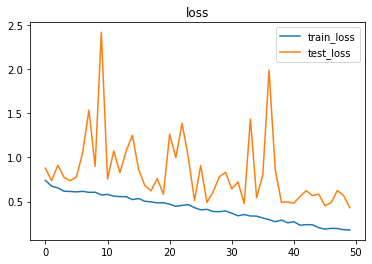

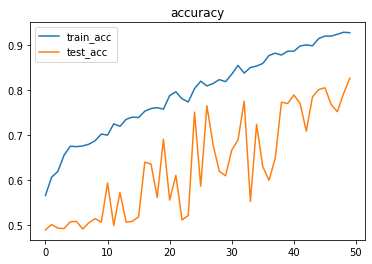

In [21]:
# 可视化训练过程
plt.title("loss")
plt.plot(train_loss_results, label='train_loss')
plt.plot(test_loss_results, label='test_loss')
plt.legend()

plt.figure()
plt.title("accuracy")
plt.plot(train_acc_results, label='train_acc')
plt.plot(test_acc_results, label='test_acc')
plt.legend()